# Named Enitity Recognition
Named Entity Recognition (NER) is an NLP problem, which involves locating and classifying named entities (people, places, organizations etc.) mentioned in unstructured text. This problem is used in many NLP applications that deal with use-cases like machine translation, information retrieval, chatbots and others.



# Load Dataset

In [55]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhinavwalia95/entity-annotated-corpus")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'entity-annotated-corpus' dataset.
Path to dataset files: /kaggle/input/entity-annotated-corpus


# Imports

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout


In [57]:
import os
os.listdir(path)

['ner.csv', 'ner_dataset.csv']

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_df = pd.read_csv(os.path.join(path,'ner_dataset.csv'),encoding='latin1')
data_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [59]:
data_df.tail()

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


Looking at the data, Sentence id is given one per sentence so we fill these missing values by method `ffill`.

In [60]:
data_df = data_df.fillna(method="ffill")
data_df["Sentence #"] = data_df["Sentence #"].apply(lambda s: s[9:])
data_df["Sentence #"] = data_df["Sentence #"].astype("int32")
data_df.head()

/tmp/ipython-input-2836681868.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_df = data_df.fillna(method="ffill")


,Sentence #,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O


In [61]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 47,959
Total words in the dataset: 1,048,575


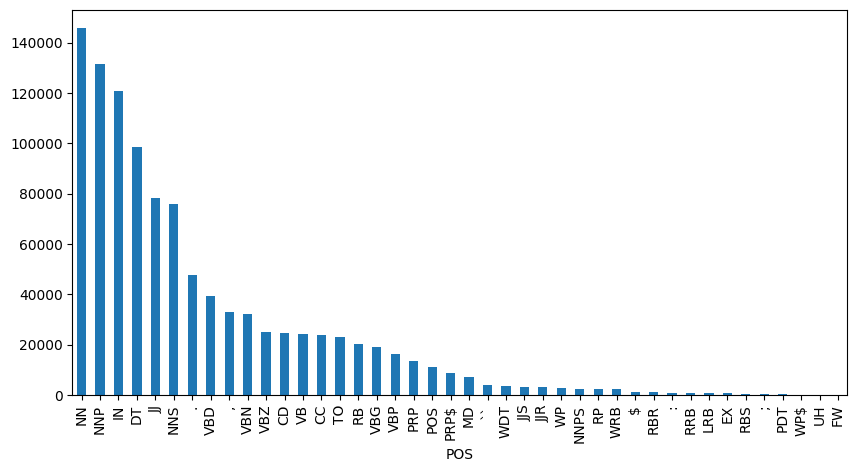

In [62]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

We notice that the top 5 parts of speech in the corpus are:

- NN - noun (e.g. table)
- NNP - proper noun (e.g. John)
- IN - preposition (e.g. in, of, like)
- DT - determiner (the)
- JJ - adjective (e.g. green)

<Axes: xlabel='Tag'>

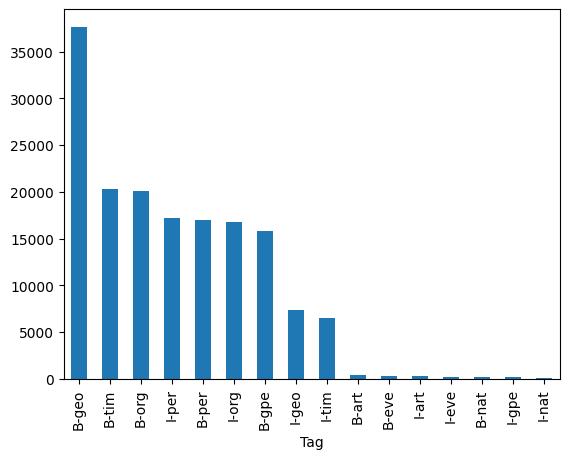

In [63]:
data_df[data_df['Tag'] !='O']['Tag'].value_counts().plot(kind = 'bar')

For visualizing Tag column i remove `O` becuase it appear 80% of the data so look at this many of our sentence start from B-geo B-time,B-org.

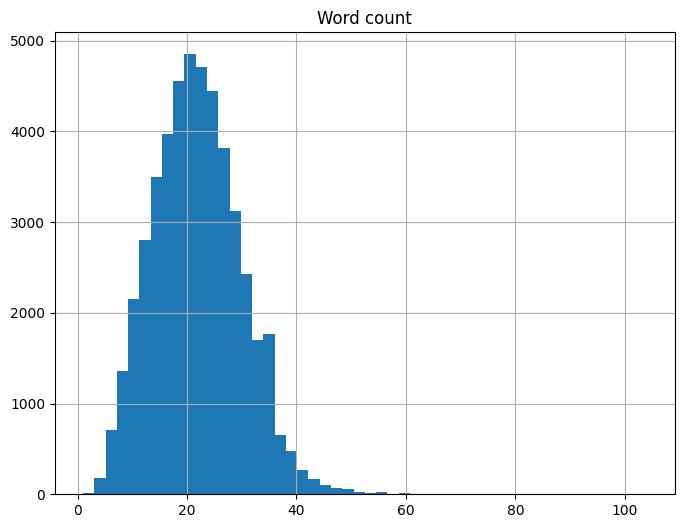

In [64]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

The average range of words in sentence is 20-22. There are some huge sentence also. The largest sentence has 104 words.

In [65]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 104 words.


/tmp/ipython-input-1099947623.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  MAX_SENTENCE = word_counts.max()[0]


In [66]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 22480.


In [67]:
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

Fisheries in 2006 - 7 landed 1,26,976 metric tons , of which 82 % ( 1,04,586 tons ) was krill ( Euphausia superba ) and 9.5 % ( 12,027 tons ) Patagonian toothfish ( Dissostichus eleginoides - also known as Chilean sea bass ) , compared to 1,27,910 tons in 2005 - 6 of which 83 % ( 1,06,591 tons ) was krill and 9.7 % ( 12,396 tons ) Patagonian toothfish ( estimated fishing from the area covered by the Convention of the Conservation of Antarctic Marine Living Resources ( CCAMLR ) , which extends slightly beyond the Southern Ocean area ) .


In [68]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tag"].values))

print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tag"].nunique()))

Number of unique words: 35177
Number of unique tags : 17


Number of unique words in the dataset are 35177 and it become 35179 when we add some extra words like pad and unknown for padding and unknown words in the dataset

In [69]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In this step we do feature engineering becuase it necessary for our model. For lstm model we convert words into numbers that way we do word2index for all the data

In [70]:
test_word = "Scotland"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word Scotland is 23877.
The word with index 23877 is Scotland.


In [71]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

Next, we write a custom function that will iterate over each sentence, and form a tuple consisting of each token, the part of speech the token represents, and its tag. We apply this function to the entire dataset and then see what the transformed version of the first sentence in the corpus looks like.

In [72]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


/tmp/ipython-input-3085017882.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()


Now we iterate every sentence and in every sentence we get word('demonstrators','NNS','O') we get demonstrators.Becuase it is input for our model we do not need POS column becuase it is not nessary and Tag is our output column.

In [73]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


We assign index to every word in the sentence. So we proceed to this number to our model not words.

In [74]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [8278, 31474, 6655, 34239, 31952, 23073, 11302, 24374, 28432, 18217, 33691, 17458, 1198, 2764, 20500, 18217, 11369, 31474, 21481, 29930, 14234, 22435, 14345, 13425]
y[0]: [13, 13, 13, 13, 13, 13, 6, 13, 13, 13, 13, 13, 6, 13, 13, 13, 13, 13, 5, 13, 13, 13, 13, 13]


We know that for lstm we must give same length of sentence to our model.So we do padding for every sentence with max_len of 75.

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 75

# Pad X (word indices)
X = pad_sequences(sequences=X,
                  maxlen=MAX_LEN,
                  padding='post',
                  value=word2index["--PADDING--"])

# Pad y (tag indices)
y = pad_sequences(sequences=y,
                  maxlen=MAX_LEN,
                  padding='post',
                  value=tag2index["--PADDING--"])


In [76]:
TAG_COUNT = len(tag2index)
y = [np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [ 8278 31474  6655 34239 31952 23073 11302 24374 28432 18217 33691 17458
  1198  2764 20500 18217 11369 31474 21481 29930 14234 22435 14345 13425
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1]
y[0]: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 43163
Number of sentences in the test dataset : 4796


In [78]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [79]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [80]:
from keras import layers
from keras import optimizers
from keras.models import Model

# Why we use BiLSTM(SOFTMAX) instead of BiLSTM-CRF.
I try many time BiLSTM-CRF but did not get result from this model becuase i face many errors and challenges when i applied this technique. Such as CRF is old technique and we use `keras_contrib` class which is not available for python 3.12.12 for my default version of python in google colab and also it requires Tensorflow>2.11.0 We wen it downgrade my python and tensorflow. There are more problems I face so instead of applying this old technique i went to apply softmax which is better for tensorflow ==2.19.0 and don't throw errors.The best part is the accuracy also similar to the bilstm-crf

In [84]:
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=WORD_COUNT, output_dim=128, input_length=MAX_LEN)(input)
model = Dropout(0.3)(model)
model = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, recurrent_dropout=LSTM_DROPOUT))(model)
out = TimeDistributed(Dense(TAG_COUNT, activation="softmax"))(model)

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 75, 128)        │     4,502,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 100)        │        71,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 75, 18)         │         1,818 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,576,330 (17.46 MB)

 Trainable params: 4,576,330 (17.46 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 76s 420ms/step - accuracy: 0.8784 - loss: 0.5879 - val_accuracy: 0.9595 - val_loss: 0.1379
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 61s 404ms/step - accuracy: 0.9661 - loss: 0.1185 - val_accuracy: 0.9817 - val_loss: 0.0709
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 60s 397ms/step - accuracy: 0.9840 - loss: 0.0622 - val_accuracy: 0.9867 - val_loss: 0.0468
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 60s 398ms/step - accuracy: 0.9885 - loss: 0.0422 - val_accuracy: 0.9886 - val_loss: 0.0387
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step - accuracy: 0.9905 - loss: 0.0344 - val_accuracy: 0.9895 - val_loss: 0.0348


In [86]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step
Accuracy: 0.9895/


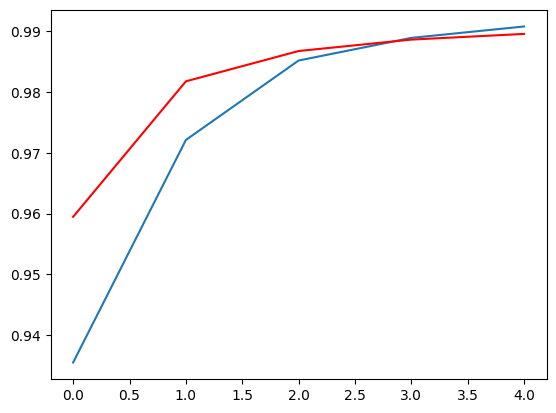

In [89]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],color = 'red')
plt.show()

It appears that the model is doing quite well, however this is slightly misleading. This is a highly imbalanced dataset because of the very high number of O-tags that are present in the training and test data. There is further imbalance between the samples including the various tag classes. A better inspection would be to construct confusion matrices for each tag and judge the model performance based on those. We can construct a simple Python function to assist with inspection of the confusion matrices for individual tags. We use two randomly selected tags to give us a sense of what the confusion matrices for individual tags would look like.

In [91]:
from sklearn.metrics import multilabel_confusion_matrix
def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: I-art
[[359666      0]
 [    34      0]]
Tag accuracy: 1.000 

Tag name: B-per
[[357826    249]
 [   361   1264]]
Tag accuracy: 0.998 



In this function we take a sentence to predict its ner and we remove unnecessary words like .>, If a word isn’t in the vocabulary, it uses the "--UNKNOWN_WORD--" index instead. and then we give intergerid to every word for this sentence and then we padd with the same length we give this to earlier. This pads short sentences with "--PADDING--" tokens at the end.It pairs each word with its predicted tag (index2tag[p]).pred[:len(sentence_words)] ignores the padded part.It prints neatly formatted output.

In [93]:
import string
import re
def predict_sentence(sentence, model, word2index, index2tag, MAX_LEN=75):
    # Tokenize sentence (basic punctuation separation)
    re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
    sentence_words = re_tok.sub(r" \1 ", sentence).split()

    # Convert words to indices
    X = [word2index.get(w, word2index["--UNKNOWN_WORD--"]) for w in sentence_words]

    # Pad sequence (same as training)
    X = pad_sequences(maxlen=MAX_LEN, sequences=[X], padding="post", value=word2index["--PADDING--"])

    # Predict using trained model
    pred = model.predict(X)
    pred = np.argmax(pred, axis=-1)[0]  # take first sentence’s predictions

    # Decode tags
    retval = ""
    for w, p in zip(sentence_words, pred[:len(sentence_words)]):  # ignore padding predictions
        retval += f"{w:15}: {index2tag[p]}\n"

    print(retval)

In [94]:
test_sentence = "Ali lives in Lahore and works at Google."
predict_sentence(test_sentence, model, word2index, index2tag, MAX_LEN=75)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Ali            : B-per
lives          : O
in             : O
Lahore         : B-geo
and            : O
works          : O
at             : O
Google         : B-org
.              : O



# Summary
this is our model for named_entity_recognition with bilstm(softmax) not crf it predict actually well with the unseen data also. Next we do same with bert. If you find this notebook helpful please like it.

In [95]:
model.save('simple_ner.h5')